In [27]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [15]:
#Get the stock
df = web.DataReader('PBR', data_source='yahoo', start='2012-01-01', end='2020-06-16')
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,26.340000,25.320000,25.370001,26.110001,12754300.0,23.543062
2012-01-04,26.580000,25.910000,25.910000,26.459999,12351500.0,23.858648
2012-01-05,26.370001,25.870001,26.309999,26.110001,8568600.0,23.543062
2012-01-06,26.250000,25.639999,26.250000,25.690001,8532100.0,23.164352
2012-01-09,26.969999,25.930000,26.080000,26.879999,26046600.0,24.237358
...,...,...,...,...,...,...
2020-06-10,9.360000,8.890000,9.360000,8.890000,33793500.0,8.890000
2020-06-11,8.550000,8.030000,8.200000,8.090000,43265600.0,8.090000
2020-06-12,8.710000,8.150000,8.500000,8.480000,33620800.0,8.480000


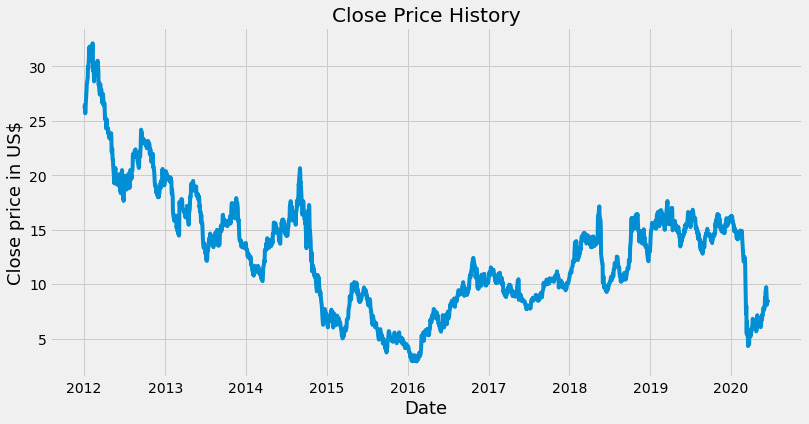

In [16]:
#Visualize the closing price history
plt.figure(figsize=(12,6))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close price in US$', fontsize=18)
plt.show()

In [24]:
#New DF with only the close column
df_close = df.filter(['Close'])

#Convert the df_close to numpy.array
dataset = df_close.values

#Get the number of rows to train our dataset
training_dataset_len = math.ceil(len(dataset) * 0.8)

In [25]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)


In [26]:
#Create the training dataset
train_data = scaled_data[:training_dataset_len , :]

#Split the data in x_train and y_train data sets
x_train = []
y_train = []

for i in range (60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i,0])

[array([0.79431901, 0.80629705, 0.79431901, 0.77994529, 0.82067077,
       0.84017802, 0.84565371, 0.86618754, 0.87132107, 0.89219713,
       0.92710475, 0.92607803, 0.92128681, 0.96509245, 0.98049282,
       0.98939085, 0.96885695, 0.96543469, 0.95242986, 0.94626969,
       0.96714582, 0.96543469, 0.96885695, 0.97672832, 0.99657774,
       1.        , 0.99555102, 0.91273103, 0.93223821, 0.89425057,
       0.88021909, 0.90485972, 0.90417524, 0.90041068, 0.90999318,
       0.91409999, 0.93018484, 0.92539362, 0.94045175, 0.92197129,
       0.94284743, 0.94524303, 0.91444222, 0.86995211, 0.86926763,
       0.87679676, 0.85660511, 0.83846682, 0.87234772, 0.87097883,
       0.85694735, 0.8524983 , 0.8542095 , 0.83675569, 0.83230665,
       0.81348395, 0.82340862, 0.84086243, 0.82717319, 0.80800825])]
[0.8045859236196595]



In [28]:
#Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)


In [31]:
#Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [32]:
#Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [33]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [34]:
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

Epoch 1/1
1642/1642 [==============================] - 64s 39ms/step - loss: 0.0015


In [37]:
#Create the testing dataset
#Create a new array containing scaled values from index x_train.shape[0](1642)
test_data = scaled_data[training_dataset_len - 60: , :]

#Create the x_test and y_test
x_test = []
y_test = dataset[training_dataset_len:, :]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i,0])

In [38]:
#Convert the data to numpy array
x_test = np.array(x_test)

In [40]:
#Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [41]:
#Get the model predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [42]:
#Get the root mean squared erros (RMSE)
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

0.30325444053201117

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


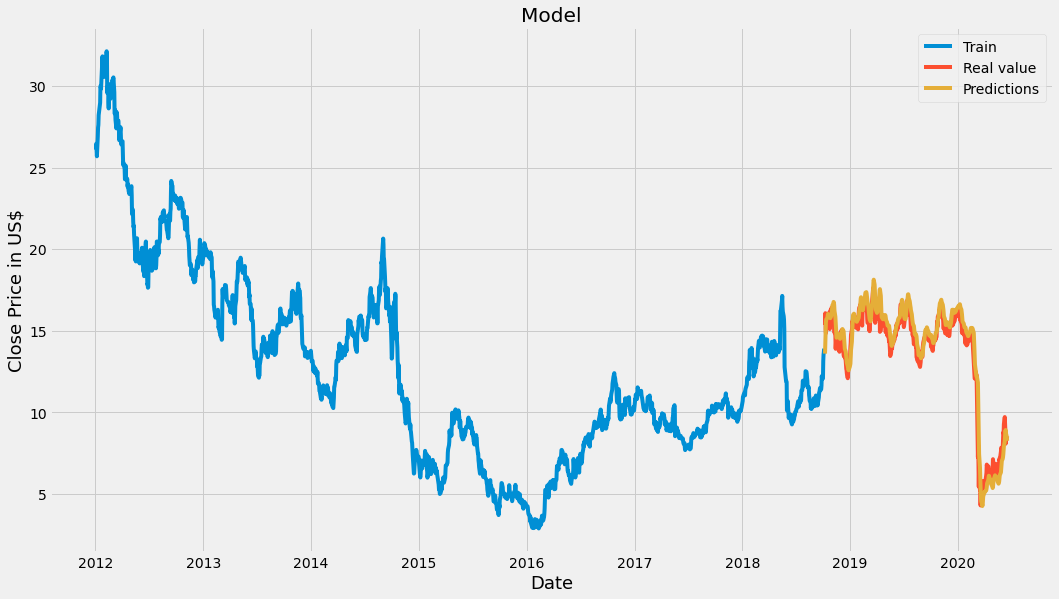

In [47]:
#Plot the data
train = df_close[:training_dataset_len]
valid = df_close[training_dataset_len:]
valid['Predictions'] = predictions

#Visualize the data
plt.figure(figsize=(16,9))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price in US$', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Real value', 'Predictions'])
plt.show()